# Task 3.1 - Analysis Report Preparation
## Project Structure

This notebook contains the solution to Task 3.1:

```Please, show the approaches in data analysis and visualization known to you. Feel free use any tools, technics, and approaches to complete the task:
• Examine the data set and carry out the analysis. We expect some report on your research that would show the performance of released changes in the
game and other interesting facts that you’re able to find in the data set. It’s supposed to be the report for business stakeholders who make decision
about launched improvements.
• Based on the results of the generated report, briefly describe the observations and conclusions that you made when processing and analyzing the data.
```

The analysis is structured as follows:

1. **AB-test analysis**  
   I begin by exploring the dataset, checking the quality of the data, and understanding the overall structure and patterns.  
   I treat the data as part of an A/B test, checking group balance and distributions.

2. **Cohort Analysis**  
   I build cohorts based on user registration or activity and analyze retention and behavior patterns over time.

3. **Visualization and Interpretation**  
   I use visualizations to highlight key findings and trends, and I provide clear conclusions based on the data.

Each step includes explanations, intermediate results, and final insights.


In [646]:
import os
from typing import List, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import ks_2samp, shapiro
from sqlalchemy import create_engine, text
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [586]:
env_path = "/Users/alena/MyPythonProjects/dataPS.env"
load_dotenv(dotenv_path=env_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("DB_NAME")

In [429]:
engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

## A/B Test Analysis
### 1. Dataset Overview

The dataset data_1.csv (table Battles) contains battle-level data from an A/B experiment conducted in an online game. Players are split into two groups based on the availability of changes in game settings and configurations:

Group A — had access to the new changes starting from October 27, 2022.
Group B — did not have access to the changes throughout the experiment period.
The dataset covers player activity between October 11, 2022 and November 29, 2022.

**Field descriptions:**

- `player_id`: Unique identifier of a player  
- `battle_id`: Unique identifier of a battle (shared by all participants in the same battle)  
- `dt`: Date when the battle occurred  
- `player_group`: A/B group assignment  
- `in_battle_presence_time`: Time (in seconds) the player was present in a battle  
- `damage_dealt`: Damage dealt to enemy vehicles during the battle  
- `kills_made`: Number of tanks destroyed by the player in the battle  
- `vehicle_lvl`: Vehicle level used in the battle  
- `account_created_at`: Timestamp of the player's account creation
- `dt_d`: Date when the battle occurred type DATE
- `account_created_at_d`: Timestamp of the player's account creation type DATE

### 2. Experiment Timing and Structure

The experiment has a **clear pre-test and post-test phase**:

- **Pre-experiment period**: October 11 – October 26, 2022  
- **Post-experiment period**: October 27 – November 29, 2022 (Group A exposed to changes)

This allows us to compare performance metrics both **before and after** the intervention.

---

### 3. Group Imbalance

Upon initial inspection, the number of unique players is **not balanced** between groups:

- Group A has **fewer unique players** than Group B.

This imbalance will be taken into account during analysis. In particular, I will:

- Check group similarity on key metrics during the pre-test period (*sanity checks*)  
- Use normalized or per-user metrics to control for unequal sample sizes  
- Consider bootstrapping or non-parametric tests if assumptions of standard parametric tests are violated

## A/B Test Logic and Metrics Selection

Before analyzing the A/B test results, it's essential to define the evaluation metrics. In a production environment, these metrics are typically selected **before** the test begins, in order to determine sample size, test duration, and evaluation criteria. However, in this assignment, no specific metrics or context around the tested changes were provided. Therefore, I selected metrics based on available data and industry best practices in game analytics.

---

### Available Metrics in the Dataset

From the dataset, the following metrics can be derived:

1. **Average in-battle presence time** — proxy for *player engagement*  
2. **Average damage dealt per player** — proxy for *activity*  
3. **Average kills per player** — another proxy for *activity*
4. **Count battles per player** — proxy for *player engagement* 
5. **Change in vehicle level over time** — proxy for *player progression*, which reflects both engagement and activity  
6. **DAU / WAU** — standard metrics for *engagement* and *player base activity*  
7. **Retention (D1, D7, D30)** — core metrics for *engagement and loyalty*  
8. **Churn rate** — inverse of retention; important for measuring *player loss*

---

### Metric Strategy

For this analysis, I define:

- **Primary Metric**:  
  - **DAU (Daily Active Users)** — This metric captures short-term player engagement and is commonly used to measure the immediate impact of changes in live service games.
  
- **Secondary Metrics**:  
  - **Average in-battle presence time** — To assess depth of engagement per session  
  - **D7 Retention** — To evaluate medium-term user retention and stickiness
  - **Count battles per player** - To assess depth of engagement

These metrics were chosen to balance **short-term behavioral response (DAU, presence time)** with **longer-term retention signals (D7), Count battles per player**.

---

Next, I proceed with preparing and aggregating the necessary data using SQL for further analysis in Python.

## Data aggregation in PostgresSQL

In [433]:
sample_data = text(
    """
  SELECT *
  FROM battles
  WHERE dt_d < '2022-10-27';
    """
)
with engine.connect() as conn:
    df_sample_data = pd.read_sql(sample_data, conn)

In [434]:
sample_dau_before_test = text(
    """
WITH daily_totals AS (
  SELECT dt_d, player_group, COUNT(DISTINCT player_id) AS daily_dau
  FROM battles
  WHERE dt_d < '2022-10-27'
  GROUP BY dt_d, player_group
),
group_sizes AS (
  SELECT player_group, COUNT(DISTINCT player_id) AS group_size
  FROM battles
  WHERE dt_d < '2022-10-27'
  GROUP BY player_group
),
group_stats AS (
  SELECT
    player_group,
    AVG(daily_dau) AS mean_dau,
    STDDEV_SAMP(daily_dau) AS std_dau
  FROM daily_totals
  GROUP BY player_group
)

SELECT distinct
  d.dt_d,
  d.player_group,
  d.daily_dau,
  1.0 * d.daily_dau / g.group_size AS dau_rate,
  ROUND((d.daily_dau - s.mean_dau) / NULLIF(s.std_dau, 0), 4) AS z_score
FROM daily_totals d
                  
JOIN group_stats s
  ON d.player_group = s.player_group

JOIN group_sizes g 
  ON d.player_group = g.player_group
                  
ORDER BY d.player_group, d.dt_d
;
"""
)

with engine.connect() as conn:
    df_sample_dau_before_test = pd.read_sql(sample_dau_before_test, conn)

In [436]:
sample_dau_test = text(
    """
WITH daily_totals AS (
  SELECT dt_d, player_group, COUNT(DISTINCT player_id) AS daily_dau
  FROM battles
  WHERE dt_d >= '2022-10-27'
  GROUP BY dt_d, player_group
),
group_sizes AS (
  SELECT player_group, COUNT(DISTINCT player_id) AS group_size
  FROM battles
  WHERE dt_d >= '2022-10-27'
  GROUP BY player_group
),
group_stats AS (
  SELECT
    player_group,
    AVG(daily_dau) AS mean_dau,
    STDDEV_SAMP(daily_dau) AS std_dau
  FROM daily_totals
  GROUP BY player_group
)

SELECT distinct
  d.dt_d,
  d.player_group,
  d.daily_dau,
  1.0 * d.daily_dau / g.group_size AS dau_rate,
  ROUND((d.daily_dau - s.mean_dau) / NULLIF(s.std_dau, 0), 4) AS z_score
FROM daily_totals d
                  
JOIN group_stats s
  ON d.player_group = s.player_group

JOIN group_sizes g 
  ON d.player_group = g.player_group
                  
ORDER BY d.player_group, d.dt_d
;
"""
)

with engine.connect() as conn:
    df_sample_dau_test = pd.read_sql(sample_dau_test, conn)

In [439]:
retentiond7_before_test = text(
    """
WITH base AS (
  SELECT DISTINCT 
    player_id, 
    player_group, 
    account_created_at_d
  FROM battles
  WHERE dt_d < '2022-10-27'
),

activity_d7 AS (
  SELECT DISTINCT battles.player_id
  FROM battles
  
  INNER JOIN base 
  	ON battles.player_id = base.player_id
	  
  WHERE battles.dt_d = base.account_created_at_d + INTERVAL '7 days'
)

SELECT distinct
  base.player_group,
  COUNT(DISTINCT base.player_id) AS total_users,
  COUNT(DISTINCT a.player_id) AS retained_users,
  ROUND(COUNT(DISTINCT a.player_id)::numeric / COUNT(DISTINCT base.player_id), 4) AS retention_d7
FROM base

LEFT JOIN activity_d7 a 
	ON base.player_id = a.player_id
	
GROUP BY base.player_group;
"""
)

with engine.connect() as conn:
    df_retentiond7_before_test = pd.read_sql(retentiond7_before_test, conn)

In [690]:
retentiond7_test = text(
    """
WITH base AS (
  SELECT DISTINCT 
    player_id, 
    player_group, 
    account_created_at_d
  FROM battles
  WHERE dt_d >= '2022-10-27'
),

activity_d7 AS (
  SELECT DISTINCT battles.player_id
  FROM battles
  
  INNER JOIN base 
  	ON battles.player_id = base.player_id
	  
  WHERE battles.dt_d = base.account_created_at_d + INTERVAL '7 days'
)

SELECT distinct
  base.player_group,
  COUNT(DISTINCT base.player_id) AS total_users,
  COUNT(DISTINCT a.player_id) AS retained_users,
  ROUND(COUNT(DISTINCT a.player_id)::numeric / COUNT(DISTINCT base.player_id), 4) AS retention_d7
FROM base

LEFT JOIN activity_d7 a 
	ON base.player_id = a.player_id
	
GROUP BY base.player_group;
"""
)

with engine.connect() as conn:
    df_retentiond7_test = pd.read_sql(retentiond7_test, conn)

In [443]:
sample_meantime_before_test = text(
    """
WITH stats AS (
    SELECT 
        player_group,
        AVG(in_battle_presence_time) AS mean_time,
        STDDEV(in_battle_presence_time) AS stddev_time
    FROM battles
    WHERE dt_d < '2022-10-27'
    GROUP BY player_group
),
stats_for_players AS (
    SELECT 
		player_id,
        player_group,
        AVG(in_battle_presence_time) AS mean_time_player
    FROM battles
    WHERE dt_d < '2022-10-27'
    GROUP BY player_id, player_group
)

SELECT distinct
    s.player_id,
    s.player_group,
    sfp.mean_time_player,
    ROUND((sfp.mean_time_player - st.mean_time) / NULLIF(st.stddev_time, 0), 4) AS z_score
FROM battles s

INNER JOIN stats st 
	ON s.player_group = st.player_group

INNER JOIN stats_for_players sfp 
	ON s.player_id = sfp.player_id
	AND s.player_group = sfp.player_group
;
"""
)
with engine.connect() as conn:
    df_sample_meantime_before_test = pd.read_sql(sample_meantime_before_test, conn)

In [445]:
sample_meantime_test = text(
    """
WITH stats AS (
    SELECT 
        player_group,
        AVG(in_battle_presence_time) AS mean_time,
        STDDEV(in_battle_presence_time) AS stddev_time
    FROM battles
    WHERE dt_d >= '2022-10-27'
    GROUP BY player_group
),
stats_for_players AS (
    SELECT 
		player_id,
        player_group,
        AVG(in_battle_presence_time) AS mean_time_player
    FROM battles
    WHERE dt_d >= '2022-10-27'
    GROUP BY player_id, player_group
)

SELECT distinct
    s.player_id,
    s.player_group,
    sfp.mean_time_player,
    ROUND((sfp.mean_time_player - st.mean_time) / NULLIF(st.stddev_time, 0), 4) AS z_score
FROM battles s

INNER JOIN stats st 
	ON s.player_group = st.player_group

INNER JOIN stats_for_players sfp 
	ON s.player_id = sfp.player_id
	AND s.player_group = sfp.player_group
;
"""
)
with engine.connect() as conn:
    df_sample_meantime_test = pd.read_sql(sample_meantime_test, conn)

In [447]:
sample_battles_before_test = text(
    """
SELECT
    player_id,
    player_group,
    COUNT(DISTINCT battle_id) AS battles_count
FROM battles 
WHERE dt_d < '2022-10-27'
GROUP BY
    player_id,
    player_group;
    """
)
with engine.connect() as conn:
    df_sample_battles_before_test = pd.read_sql(sample_battles_before_test, conn)

In [449]:
sample_battles_test = text(
    """
SELECT
    player_id,
    player_group,
    COUNT(DISTINCT battle_id) AS battles_count
FROM battles 
WHERE dt_d >= '2022-10-27'
GROUP BY
    player_id,
    player_group;
    """
)
with engine.connect() as conn:
    df_sample_battles_test = pd.read_sql(sample_battles_test, conn)

## Helper Functions

### Helper functions for A/B test analysis

In [655]:
def get_column_by_player_groups(
    df: pd.DataFrame, column_name: str
) -> tuple[pd.Series, pd.Series]:
    """
    Extract data from a specific column for two player groups (A and B).

    Args:
        df (pd.DataFrame): The input DataFrame containing player data.
        column_name (str): The name of the column to extract data from.

    Returns:
        tuple[pd.Series, pd.Series]: A tuple containing two pandas Series:
            - First Series: Data for player group A
            - Second Series: Data for player group B
    """
    group_a = df[df["player_group"] == "A"][column_name]
    group_b = df[df["player_group"] == "B"][column_name]
    return group_a, group_b
    
def bootstrap_diff_mean(
    a: np.ndarray, b: np.ndarray, n_bootstrap: int, confidence_level: float = 0.95
) -> Tuple[float, float, bool, List[float]]:
    """
    Performs bootstrap resampling to estimate the confidence interval for the difference in means.

    Args:
        a: First sample data
        b: Second sample data
        n_bootstrap: Number of bootstrap iterations
        confidence_level: Confidence level for the interval (default: 0.95)

    Returns:
        Tuple containing:
        - lower: Lower bound of the confidence interval
        - upper: Upper bound of the confidence interval
        - is_significant: Whether the difference is statistically significant
        - diffs: List of all bootstrap differences
    """
    diffs = []
    for _ in range(n_bootstrap):
        sample_a = np.random.choice(a, size=len(a), replace=True)
        sample_b = np.random.choice(b, size=len(b), replace=True)
        diff = sample_b.mean() - sample_a.mean()
        diffs.append(diff)
    lower = np.percentile(diffs, (1 - confidence_level) / 2 * 100)
    upper = np.percentile(diffs, (1 + confidence_level) / 2 * 100)
    is_significant = not (lower <= 0 <= upper)
    return lower, upper, is_significant, diffs


def fpr_check(
    df: pd.DataFrame,
    column_usr: str,
    column_name: str,
    n_iterations: int = 1000,
    n_bootstrap_samples: int = 1000,
    alpha: float = 0.05,
) -> float:
    """
    Calculate the False Positive Rate (FPR) using bootstrap resampling.

    This function performs random permutations of player groups and uses bootstrap
    sampling to estimate the false positive rate when testing for differences
    between two groups.

    Args:
        df: DataFrame containing the data
        column_usr: Name of the column for agregate
        column_name: Name of the column to analyze
        n_iterations: Number of permutation iterations (default: 1000)
        n_bootstrap_samples: Number of bootstrap samples per iteration (default: 1000)
        alpha: Significance level for confidence interval (default: 0.05)

    Returns:
        float: The calculated false positive rate
    """
    # Get data
    df_copy = df.copy()
    group_a, group_b = get_column_by_player_groups(df_copy, column_name)

    # Get group sizes
    player_ids = df_copy[column_usr].unique()
    group_a_size = len(np.unique(group_a))
    group_b_size = len(np.unique(group_b))

    # Counter for false positives
    false_positive_count = 0

    for _ in tqdm(range(n_iterations)):
        # Randomly shuffle IDs and split into groups
        shuffled_ids = np.random.permutation(player_ids)
        group_a_ids = shuffled_ids[:group_a_size]
        group_b_ids = shuffled_ids[group_a_size : group_a_size + group_b_size]

        # Extract values for each group
        group_a_values = df_copy[df_copy[column_usr].isin(group_a_ids)][
            column_name
        ].values
        group_b_values = df_copy[df_copy[column_usr].isin(group_b_ids)][
            column_name
        ].values

        ci_lower, ci_upper, is_significant, bootstrap_diffs = bootstrap_diff_mean(
            group_a_values, group_b_values, n_bootstrap_samples
        )
        # Check if 0 is outside the confidence interval (false positive)
        if is_significant:
            false_positive_count += 1

    # Calculate final FPR
    fpr = false_positive_count / n_iterations
    return fpr

### Help function for visualization

In [596]:
def plot_distribution_analysis(
    data: pd.Series,
    title_prefix: str = "Distribution Analysis",
    color: str = "skyblue",
    bins: int = 20,
    figsize: tuple = (12, 5),
) -> None:
    """
    Creates a visualization with histogram (with KDE) and QQ-plot for the given data.

    Args:
        data (pd.Series): The data to analyze and visualize
        title_prefix (str): Prefix for plot titles
        color (str): Color for the histogram
        bins (int): Number of bins for the histogram
        figsize (tuple): Figure size as (width, height)

    Returns:
        None: This function displays the plots directly
    """
    # Create figure with two subplots
    plt.figure(figsize=figsize)

    # Plot histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=bins, color=color)
    plt.title(f"{title_prefix} - Histogram")
    plt.xlabel(data.name)
    plt.ylabel("Frequency")

    # Plot QQ-plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"{title_prefix} - QQ-Plot")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# A/B Test Analysis Framework

The following section presents a structured analysis of the A/B test.  
It consists of the following steps:

1. **Pre-Test Validation: Sampling and Split Check**  
   Ensure the control and test groups were randomly and independently assigned.

2. **Data Distribution Exploration**  
   Analyze metric distributions and assess normality assumptions to choose appropriate statistical tests.

3. **Statistical Testing**  
   Apply hypothesis testing methods to evaluate the significance of differences between groups.

4. **Results Overview**  
   Present key findings from the analysis in tables and visualizations.

5. **Conclusions**  
   Summarize the outcome of the test, interpret results in the context of the experiment, and provide actionable recommendations.

## Pre-Test Validation: Sampling and Split Check

Since the dataset includes a pre-experiment period, I can validate the split logic to ensure that the treatment and control groups were formed randomly and without systematic bias. This step is critical for the integrity of any A/B test.

To validate the split, I consider three common techniques:

1. **SRM Check (Sample Ratio Mismatch)**  
   This test compares the actual user split between groups to the expected ratio (e.g., 50/50).  
   In this case, the expected ratio was not provided, so I skip this step.  
   However, in a real-world scenario, SRM is a mandatory validation step before proceeding with any test analysis.

2. **Intersection Check**  
   This ensures that no users appear in both groups. The presence of overlapping users would invalidate the assumption of independent groups.

3. **False Positive Rate (FPR) Check**  
   This test simulates A/A comparisons during the pre-experiment period. If statistically significant differences are found when no treatment was applied, it suggests issues with the randomization process.

---

Performing these checks allows us to catch implementation errors early and avoid misinterpreting test results due to flawed group assignments.


### Intersection Check

In [465]:
group_a, group_b = get_column_by_player_groups(df_sample_data, "player_id")

intersection = pd.merge(group_a, group_b, on="player_id")

if intersection.empty:
    print("No players exist in both groups.")
else:
    print(f"Found {len(intersection)} players in both groups:")
    print(intersection)

No players exist in both groups.


### False Positive Rate (FPR) Check

#### FPR Check for Mean time in battle

In [469]:
fpr = fpr_check(df_sample_meantime_before_test, "player_id", "mean_time_player")
print("Bootstrap FPR: ", fpr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.38it/s]

Bootstrap FPR:  0.049


The bootstrap-based FPR is ~0.05, which is within the acceptable range.  
This suggests the group split was implemented correctly and no systemic bias is present.

#### FPR Check for count of battles

In [472]:
fpr = fpr_check(df_sample_battles_test, "player_id", "battles_count")
print("Bootstrap FPR: ", fpr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.43it/s]

Bootstrap FPR:  0.052


The bootstrap-based FPR is ~0.05, which is within the acceptable range.
This suggests the group split was implemented correctly and no systemic bias is present.

## Data Distribution Exploration

To check whether the data follows a normal distribution, I applied the **normal test and Shapiro test**.

#### Data Distribution Exploration: metric - Mean time in battle

In [635]:
group_a, group_b = get_column_by_player_groups(df_sample_meantime_test, "mean_time_player")

print("Analys Group A:")
stat, p_value = stats.normaltest(group_a.dropna())

if p_value < 0.05:
    print(f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}")
else:
    print(f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}")
    
print("\nAnalys Group B:")
stat, p_value = stats.normaltest(group_b.dropna())

if p_value < 0.05:
    print(f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}")
else:
    print(f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}")

Analys Group A:
The data is not normally distributed. Statistic: 268.5002092747138, p-value: 4.965012669676625e-59

Analys Group B:
The data is not normally distributed. Statistic: 25.146953651840906, p-value: 3.4626484077667783e-06


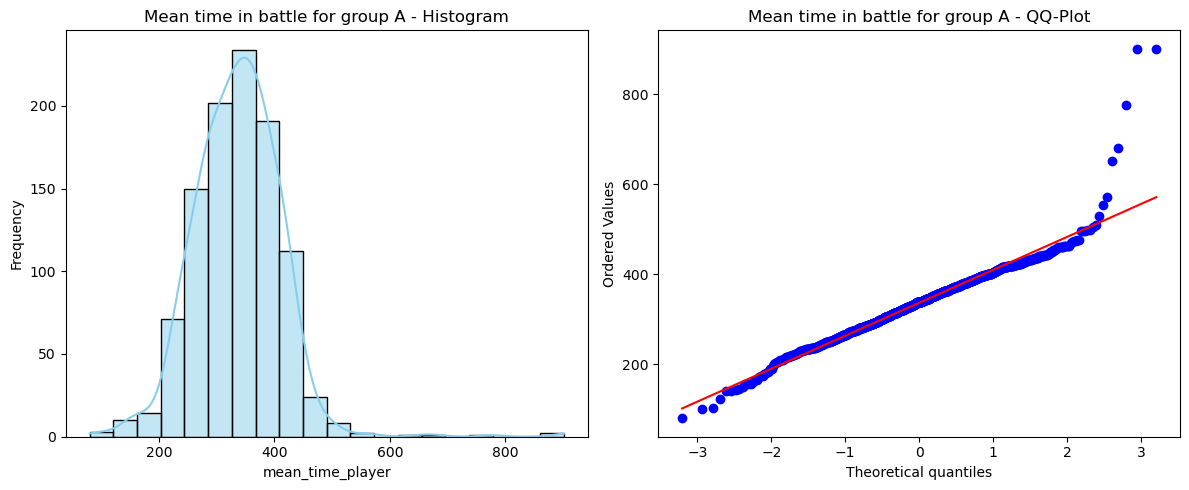

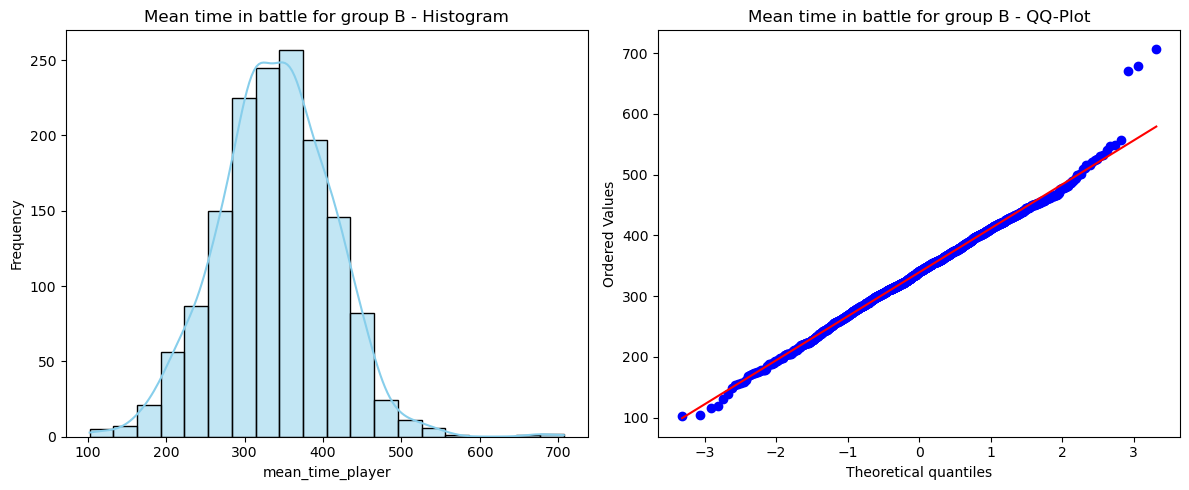

In [608]:
group_a, group_b = get_column_by_player_groups(df_sample_meantime_test, "mean_time_player")

plot_distribution_analysis(group_a, title_prefix="Mean time in battle for group A")
plot_distribution_analysis(group_b, title_prefix="Mean time in battle for group B")

#### Metric Distribution & Statistical Test Selection for metric - mean time in battle

Based on the results of the Kolmogorov–Smirnov test and visualization, the distribution of the metric *average time spent in battle* in both groups does not follow a normal distribution. As a result, standard parametric methods (e.g., t-test) are not suitable for computing the p-value.

Instead, I will use **bootstrapping** to estimate the distribution of the difference between groups and calculate a confidence interval for this difference.

> *Note:* A non-parametric test such as the **Mann–Whitney U test** is often used as an alternative. However, it assumes that the distributions of both groups have the same shape (i.e., same form).  
> In this case, I decided not to use Mann–Whitney, as verifying this assumption would require additional checks and the resulting p-value might be less informative than a directly interpreted confidence interval.


#### Data Distribution Exploration: metric - DAU
I used the Shapiro-Wilk test to assess normality because the sample size is relatively small, and this test is more reliable than others for small datasets.

In [648]:
group_a, group_b = get_column_by_player_groups(df_sample_dau_test, "daily_dau")

from scipy.stats import shapiro
print("Analys Group A:")
stat, p_value = shapiro(group_a)

if p_value < 0.05:
    print(f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}")
else:
    print(f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}")
    
print("\nAnalys Group B:")
stat, p_value = shapiro(group_b)

if p_value < 0.05:
    print(f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}")
else:
    print(f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}")

Analys Group A:
The data is not normally distributed. Statistic: 0.88994452078537, p-value: 0.0025146776848547748

Analys Group B:
The data can be normally distributed. Statistic: 0.9669304577504113, p-value: 0.382196316261614


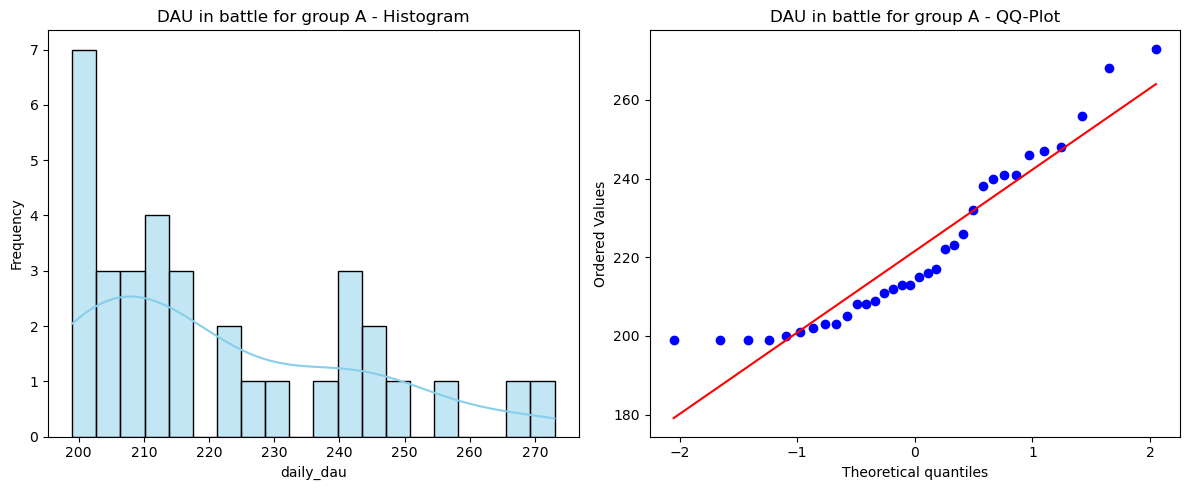

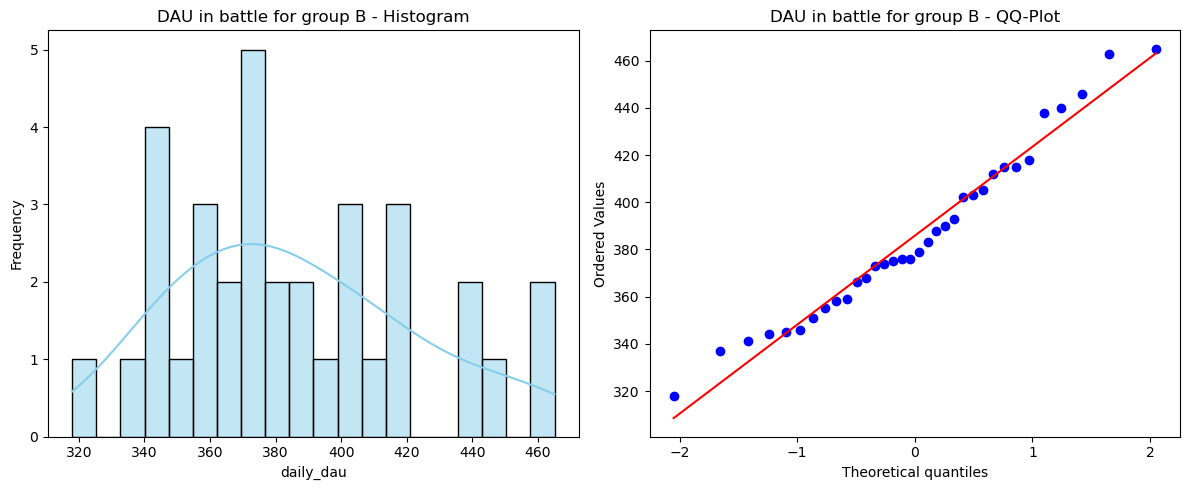

In [615]:
group_a, group_b = get_column_by_player_groups(df_sample_dau_test, "daily_dau")

plot_distribution_analysis(group_a, title_prefix="DAU in battle for group A")
plot_distribution_analysis(group_b, title_prefix="DAU in battle for group B")

#### Metric Distribution & Statistical Test Selection for metric - DAU

As the DAU metric also shows a non-normal distribution in group B, I will use **bootstrap resampling with confidence interval estimation** for its analysis in the A/B test.

#### Data Distribution Exploration: metric - Retention d7

We don't test for normality

We are comparing proportions (retention rates), which are derived from binary outcomes (1 = user returned, 0 = user did not). Since the underlying data is binomial, not continuous, normality tests like Kolmogorov-Smirnov are not applicable.

According to the Central Limit Theorem, if the sample size is large enough (np > 5 and n(1−p) > 5), the sampling distribution of the proportion approximates a normal distribution. Therefore, we can safely use the z-test without explicitly testing for normality.

#### Data Distribution Exploration: metric - Count battles per player

In [671]:
group_a, group_b = get_column_by_player_groups(df_sample_battles_test, "battles_count")

print("Analys Group A:")
stat, p_value = stats.normaltest(group_a.dropna())

if p_value < 0.05:
    print(f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}")
else:
    print(f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}")
    
print("\nAnalys Group B:")
stat, p_value = stats.normaltest(group_b.dropna())

if p_value < 0.05:
    print(f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}")
else:
    print(f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}")

Analys Group A:
The data is not normally distributed. Statistic: 837.3695257065124, p-value: 1.470678812860174e-182

Analys Group B:
The data is not normally distributed. Statistic: 1135.7586780459803, p-value: 2.3612212087589988e-247


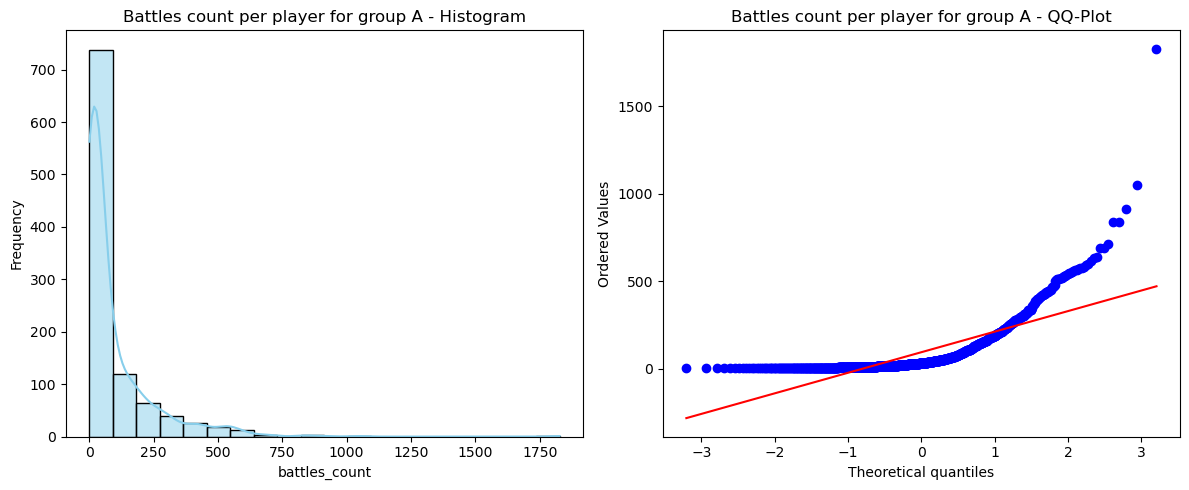

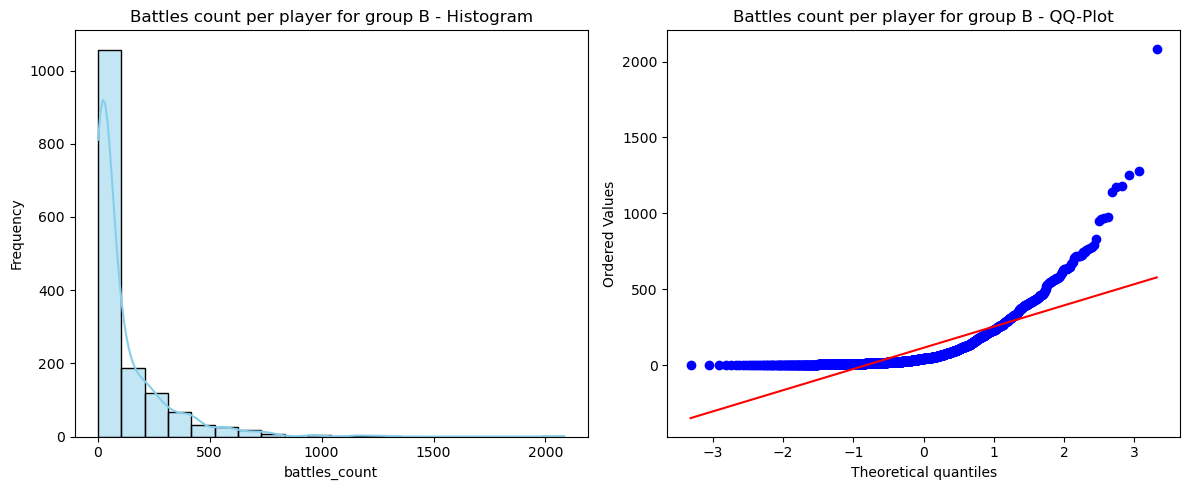

In [673]:
group_a, group_b = get_column_by_player_groups(df_sample_battles_test, "battles_count")

plot_distribution_analysis(group_a, title_prefix="Battles count per player for group A")
plot_distribution_analysis(group_b, title_prefix="Battles count per player for group B")

#### Metric Distribution & Statistical Test Selection for metric - Battles per player

As the Battles per player metric also shows a non-normal distribution, I will use **bootstrap resampling with confidence interval estimation** for its analysis in the A/B test.

## Applying Statistical Tests to the A/B Test

**Product hypothesis:**  
The change impacted DAU of users in Group A.

**Statistical hypothesis:**  
- **H0:** There is no difference in DAU between groups A and B.  
- **H1:** The metric DAU in group A will differ from DAU in group B.

In addition, we will also examine the behavior of the Retention (day 7) metric and the average time a player spends in battle.

**Statistical tests applied:**  
1. **DAU** — Bootstrap with confidence intervals  
2. **Retention (day 7)** — Z-test  
3. **Average time in battle** — Bootstrap with confidence intervals

Parameters:
- Number of bootstrap iterations: 1000  
- Significance level (α): 0.05

The analysis accounts for the fact that the initial samples were unbalanced in terms of the number of players in each group.

## Analysis of the DAU metric

In [350]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_dau_test, "daily_dau")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [150.2904, 178.2368]
The difference between the groups is statistically significant


**Conclusion:**  
Bootstrap analysis shows that the 95% confidence interval for the difference in daily active users (DAU) between control (B) and test (A) is [150.56, 177.97]. Since the entire interval is above zero, we conclude that the DAU in the test group was significantly lower than in the control group.

This indicates that the changes introduced in group A had a negative impact on user engagement, leading to an estimated drop of 150–178 daily active users.

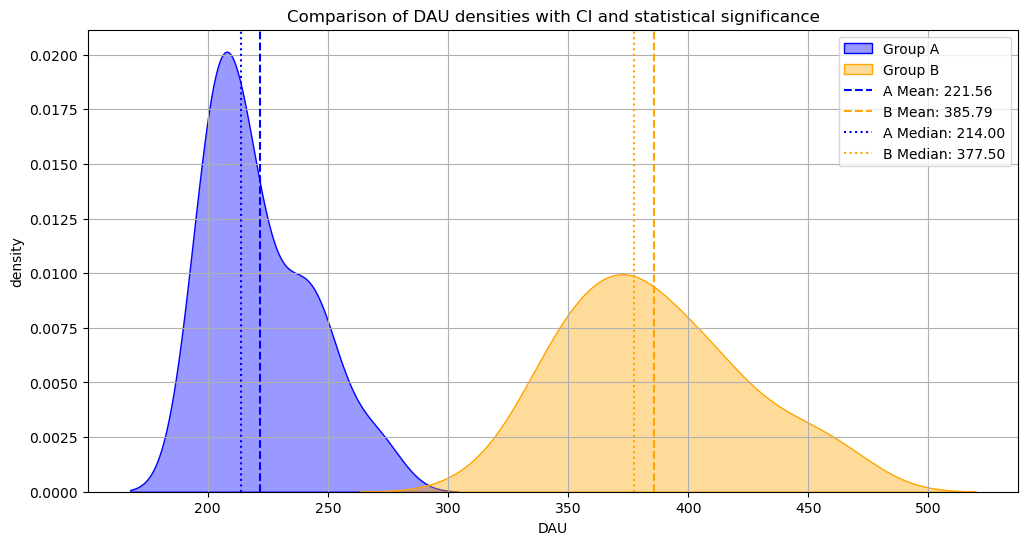

In [353]:
# KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(group_a, fill=True, label="Group A", color="blue", alpha=0.4)
sns.kdeplot(group_b, fill=True, label="Group B", color="orange", alpha=0.4)

plt.axvline(mean_A, color="blue", linestyle="--", label=f"A Mean: {mean_A:.2f}")
plt.axvline(mean_B, color="orange", linestyle="--", label=f"B Mean: {mean_B:.2f}")
plt.axvline(median_A, color="blue", linestyle=":", label=f"A Median: {median_A:.2f}")
plt.axvline(median_B, color="orange", linestyle=":", label=f"B Median: {median_B:.2f}")

plt.title("Comparison of DAU densities with CI and statistical significance")
plt.xlabel("DAU")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

## Analysis of the Count battles per player

In [577]:
n_bootstrap = 1000 
group_a, group_b = get_column_by_player_groups(df_sample_battles_test, "battles_count")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [7.3132, 32.7083]
The difference between the groups is statistically significant


**Conclusion:**  
Bootstrap analysis shows that the 95% confidence interval for the difference in Count battles per player between control (B) and test (A) is [7.3132, 32.7083]. Since the entire interval is above zero, we conclude that the Count battles per player in the test group was significantly lower than in the control group.

This result suggests that the test group played on average 7 to 33 fewer battles per player during the test period, indicating a notable decrease in user engagement.

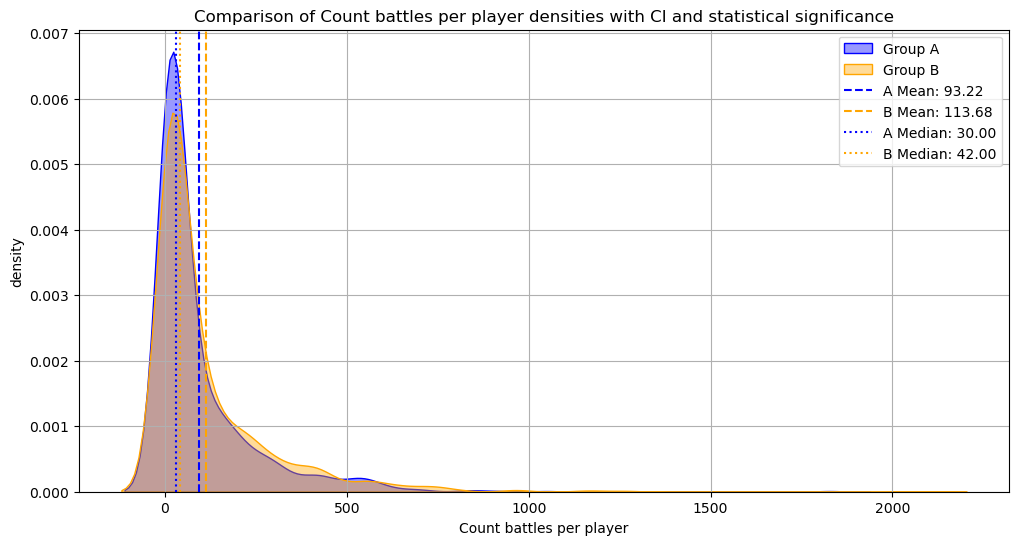

In [579]:
# KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(group_a, fill=True, label="Group A", color="blue", alpha=0.4)
sns.kdeplot(group_b, fill=True, label="Group B", color="orange", alpha=0.4)

plt.axvline(mean_A, color="blue", linestyle="--", label=f"A Mean: {mean_A:.2f}")
plt.axvline(mean_B, color="orange", linestyle="--", label=f"B Mean: {mean_B:.2f}")
plt.axvline(median_A, color="blue", linestyle=":", label=f"A Median: {median_A:.2f}")
plt.axvline(median_B, color="orange", linestyle=":", label=f"B Median: {median_B:.2f}")

plt.title("Comparison of Count battles per player densities with CI and statistical significance")
plt.xlabel("Count battles per player")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

## Analysis of the Average time in battle

In [356]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_meantime_test, "mean_time_player")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [-3.6588, 8.9563]
There is no statistically significant difference between the groups.


**Conclusion:**  
Since this interval includes zero, we cannot conclude that there is a statistically significant difference between the groups.  
In simple terms, the data does not provide strong evidence that the change affected the metric.

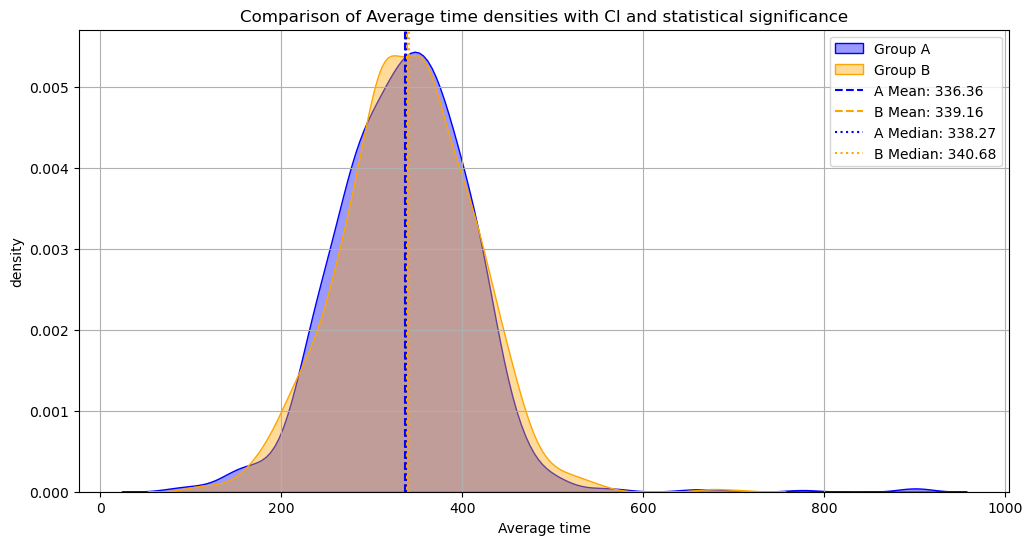

In [418]:
# KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(group_a, fill=True, label="Group A", color="blue", alpha=0.4)
sns.kdeplot(group_b, fill=True, label="Group B", color="orange", alpha=0.4)

plt.axvline(mean_A, color="blue", linestyle="--", label=f"A Mean: {mean_A:.2f}")
plt.axvline(mean_B, color="orange", linestyle="--", label=f"B Mean: {mean_B:.2f}")
plt.axvline(median_A, color="blue", linestyle=":", label=f"A Median: {median_A:.2f}")
plt.axvline(median_B, color="orange", linestyle=":", label=f"B Median: {median_B:.2f}")

plt.title("Comparison of Average time densities with CI and statistical significance")
plt.xlabel("Average time")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

## Analysis of retention d7

In [692]:
retained_a, retained_b = get_column_by_player_groups(df_retentiond7_test, "retained_users")
total_a, total_b = get_column_by_player_groups(df_retentiond7_test, "total_users")

retained = [retained_a, retained_b]
total = [total_a, total_b] 

z_stat, p_value = proportions_ztest(retained, total)
printstats(p_value, z_stat, "Z-Statistics")

There is no statistically significant difference between the groups. Z-Statistics: [-1.1727995], p-value: [0.24087622]


**Conclusion:**  
Retention D7 is not significantly different between groups (p = 0.24), but the trend is negative.

## A/B Test Results summary

#### 1. DAU (Daily Active Users)  
- **95% confidence interval for the difference in means (B - A):** [150.29, 178.24]
- **Interpretation:** The mean DAU in group B is significantly higher than in group A, as the entire interval is positive and does not include zero.  
- **Conclusion:** Variant A shows a consistent decrease in user engagement compared to B.

---

#### 2. Retention D7 (7-day retention)  
- **Z-statistic:** -1.17  
- **p-value:** 0.24  
- **Interpretation:** Retention D7 is not significantly different** between groups (p = 0.24), but the trend is negative.  
- **Conclusion:** Variant A does not impact.

---

#### 3. Average Time in Battle  
- **95% confidence interval for the difference in means (B - A):** [-3.66, 8.96]
- **Interpretation:** The interval includes zero, meaning there is no statistically significant difference in average time in battle between the groups.  
- **Conclusion:** Variant A does not impact average battle duration.

#### 4. The number of battles per player  
- **95% confidence interval for the difference in means (B - A):** [7.31, 32.71]
- **Interpretation:** The number of battles per player in group B is significantly higher than in group A, as the entire interval is positive and does not include zero.  
- **Conclusion:** Variant A shows a consistent decrease in user engagement compared to B.

---

## Recommendations and hypotheses for further analysis:

#### 1. Combat effectiveness and game progress:
- **Hypothesis**: After the change, the effectiveness of players in group A decreased (less damage dealt and fewer kills). Compare the average values of damage_dealt and kills_made per battle for new players in the test and control groups.
- **Hypothesis**: The change in group A negatively affected player progression — vehicle level (vehicle_lvl) of new players decreased. Compare the distribution of vehicle levels among new players in both groups one week after registration.

#### 2. Impact of the change on player group distribution:
- **Hypothesis**: The change may have affected different player groups (player_group) differently. Analyze key metrics (retention, DAU, damage_dealt, kills_made) across groups: new/returning players, by vehicle level, and by battle duration (high/low).

#### 3. Check relationships between metrics:
- **Hypothesis**: The drop in DAU is related to poorer combat performance (lower damage and fewer kills). Build correlations between individual combat performance metrics (damage_dealt, kills_made) and DAU.